## Project: Markov Simulation

In this project, I will write a program that simulates customer behaviour in a supermarket.

#### Load dataset


In [132]:
import os
import glob

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from random import random, randint, choices, seed
from faker import Faker
from datetime import datetime
import itertools

import warnings

warnings.filterwarnings("ignore")

%matplotlib inline

#### Reading CSVs into one dataframe

In [2]:
#getting csv from data folder
path = "./../week8/data"                      

#read all files with csv extension
filenames = glob.glob(path + "/*.csv") 
#check if all files are read
print('File :', filenames)

File : ['./../week8/data/tuesday.csv', './../week8/data/monday.csv', './../week8/data/thursday.csv', './../week8/data/wednesday.csv', './../week8/data/friday.csv']


In [3]:
#create empty list
df_list = []

for file in filenames:
    #reading and appending csv files to empty list
    df_list.append(pd.read_csv(file, delimiter=';', parse_dates=True, index_col='timestamp'))

#put together as one dataframe
df = pd.concat(df_list)                       

print(df)

                     customer_no  location
timestamp                                 
2019-09-03 07:02:00            1     fruit
2019-09-03 07:02:00            2    drinks
2019-09-03 07:03:00            3     dairy
2019-09-03 07:05:00            1    drinks
2019-09-03 07:06:00            4     dairy
...                          ...       ...
2019-09-06 21:50:00         1500     dairy
2019-09-06 21:50:00         1507  checkout
2019-09-06 21:50:00         1508  checkout
2019-09-06 21:50:00         1509    drinks
2019-09-06 21:50:00         1510    spices

[24877 rows x 2 columns]


#### Creating distinct customerID (to distinguish customer_no on different days)

In [4]:
name_of_day = df.index.day_name()
df['customerID'] = name_of_day + '_'+ df['customer_no'].astype(str)

#### Create columns for day and time for the purpose of EDA

In [5]:
df['day'] = df.index.day_name()
df['time'] = df.index.time

In [6]:
#sort the index for hygiene and peace that is needed for transition probability
df.sort_index(inplace=True)

#### Deal with shoppers that did not complete checkout

Count how many people did not complete checkout. If number is too insignificant, drop them.

In [7]:
last_section = pd.DataFrame(df.groupby('customerID')['location'].last())
x_c = last_section.loc[last_section['location'] != 'checkout']
x_c

,location
customerID,
Friday_1494,spices
Friday_1496,fruit
Friday_1500,dairy
Friday_1503,drinks
Friday_1505,dairy
Friday_1506,dairy
Friday_1509,drinks
Friday_1510,spices
Monday_1430,fruit


In [8]:
#get customerID of those that did not complete checkout
xc =[]
for customer in x_c.index:
    xc.append(customer)

xc

['Friday_1494',
 'Friday_1496',
 'Friday_1500',
 'Friday_1503',
 'Friday_1505',
 'Friday_1506',
 'Friday_1509',
 'Friday_1510',
 'Monday_1430',
 'Monday_1433',
 'Monday_1437',
 'Monday_1439',
 'Monday_1440',
 'Monday_1441',
 'Monday_1443',
 'Monday_1445',
 'Monday_1446',
 'Monday_1447',
 'Thursday_1527',
 'Thursday_1532',
 'Thursday_1533',
 'Tuesday_1411',
 'Tuesday_1422',
 'Wednesday_1520',
 'Wednesday_1527',
 'Wednesday_1528',
 'Wednesday_1529',
 'Wednesday_1530']

In [9]:
#drop them all
df = df.loc[~df['customerID'].isin(xc)]

#### To simulate customer movement

To create the transition matrix, forward fill the minutes till the next customer.

In [10]:
c_flow = df.groupby(['customerID']).resample('min').ffill()

#### Defining STATES

Or more like locations/positions

In [11]:
states = pd.DataFrame(
    {'time': list(range(len(c_flow))), # a list from 0 to the length of data array in steps of 1
    'before': c_flow['location']}
)

In [12]:
states['before'].shift(-1)

customerID     timestamp          
Friday_1       2019-09-06 07:00:00       dairy
               2019-09-06 07:01:00       dairy
               2019-09-06 07:02:00       dairy
               2019-09-06 07:03:00      spices
               2019-09-06 07:04:00    checkout
                                        ...   
Wednesday_998  2019-09-04 16:57:00       fruit
               2019-09-04 16:58:00    checkout
               2019-09-04 16:59:00       fruit
Wednesday_999  2019-09-04 16:53:00    checkout
               2019-09-04 16:54:00         NaN
Name: before, Length: 53745, dtype: object

In [13]:
states['after'] = states['before'].shift(-1)

In [14]:
states.loc[states['before'] == 'checkout', 'after'] = 'checkout'

In [15]:
states.head(20)

#force fill 'after' for checkout as checkout so checkout > checkout

time    before     after
customerID  timestamp                                    
Friday_1    2019-09-06 07:00:00     0     dairy     dairy
            2019-09-06 07:01:00     1     dairy     dairy
            2019-09-06 07:02:00     2     dairy     dairy
            2019-09-06 07:03:00     3     dairy    spices
            2019-09-06 07:04:00     4    spices  checkout
            2019-09-06 07:05:00     5  checkout  checkout
Friday_10   2019-09-06 07:06:00     6     fruit     fruit
            2019-09-06 07:07:00     7     fruit     fruit
            2019-09-06 07:08:00     8     fruit     fruit
            2019-09-06 07:09:00     9     fruit     fruit
            2019-09-06 07:10:00    10     fruit  checkout
            2019-09-06 07:11:00    11  checkout  checkout
Friday_100  2019-09-06 08:03:00    12     fruit  checkout
            2019-09-06 08:04:00    13  checkout  checkout
Friday_1000 2019-09-06 17:19:00    14     fruit  checkout
            2019-09-06 17:20:00    15  checkout  checkout
Friday_1001 2019-09-06 17:19:00    16     fruit     fruit
            2019-09-06 17:20:00    17     fruit    drinks
            2019-09-06 17:21:00    18    drinks    drinks
            2019-09-06 17:22:00    19    drinks    spices

#### Get Transitional Probabilities

In [16]:
pd.crosstab(states['before'],states['after'])

after,checkout,dairy,drinks,fruit,spices
before,,,,,
checkout,7417,0,0,0,0
dairy,1825,13073,1034,883,909
drinks,2096,106,5798,847,840
fruit,2555,1209,696,7561,642
spices,941,1210,1020,568,2515


In [17]:
P = pd.crosstab(states['before'], states['after'], normalize = 0) 
P

after,checkout,dairy,drinks,fruit,spices
before,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.102968,0.737587,0.058339,0.049819,0.051286
drinks,0.216372,0.010943,0.598534,0.087437,0.086714
fruit,0.201769,0.095475,0.054963,0.597094,0.050699
spices,0.150464,0.193476,0.163096,0.090822,0.402143


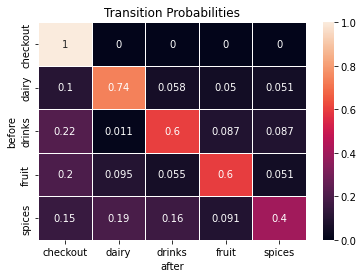

In [18]:
sns.heatmap(P, linewidth = 1, annot = True)
plt.title('Transition Probabilities')
plt.show()

#### Predicting the customer's next step with `choices`

If the customer in `location` X, where will they go next?

In [19]:
def next_location(start):
    locations = ['checkout','dairy','drinks','fruit','spices']
    return choices(locations, weights = P[P.index == start].values[0])

In [20]:
next_location('spices')

['fruit']

In [21]:
next_location('fruit')

['fruit']

In [22]:
next_location('drinks')

['drinks']

In [23]:
next_location('dairy')

['checkout']

In [24]:
next_location('checkout')

['checkout']

### MC-Simulation

Implement the following:

1. Set an initial state distribution vector with all customers in the entrance
2. Store the state distribution in a result object (list, DataFrame or similar)
3. Calculate the next state as a dot product of your transition probability matrix P
4. Repeat from 2 for a number of steps
5. Plot the result

#### Adding Entrance location to the dataset

Everyone starts from the 'Entrance' point

In [25]:
sections = ['checkout','dairy','drinks','fruit','spices','entrance']

#### Obtaining weights for Entrance to First Section

In [26]:
first_section = pd.DataFrame(df.groupby('customerID')['location'].first())

In [27]:
sec_total = first_section['location'].value_counts().sum()

#dairy
dairy_count = first_section['location'].value_counts()['dairy']
dairy_pct = dairy_count/sec_total
print('dairy :', dairy_pct)

#fruit
fruit_count = first_section['location'].value_counts()['fruit']
fruit_pct = fruit_count/sec_total
print('fruit :', fruit_pct)

#spices
spice_count = first_section['location'].value_counts()['spices']
spice_pct = spice_count/sec_total
print('spice :', spice_pct)

#drinks
drink_count = first_section['location'].value_counts()['drinks']
drink_pct = drink_count/sec_total
print('drink :', drink_pct)

dairy : 0.2866388027504382
fruit : 0.3780504247000135
spice : 0.18174464069030605
drink : 0.15356613185924228


In [28]:
nuP = np.array([0, 0.2866388027504382, 0.15356613185924228, 0.3780504247000135, 0.18174464069030605])

In [29]:
P

after,checkout,dairy,drinks,fruit,spices
before,,,,,
checkout,1.000000,0.000000,0.000000,0.000000,0.000000
dairy,0.102968,0.737587,0.058339,0.049819,0.051286
drinks,0.216372,0.010943,0.598534,0.087437,0.086714
fruit,0.201769,0.095475,0.054963,0.597094,0.050699
spices,0.150464,0.193476,0.163096,0.090822,0.402143


In [30]:
lol = P.values

In [31]:
lol

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.10296773, 0.73758745, 0.05833898, 0.04981945, 0.05128639],
       [0.21637246, 0.0109425 , 0.59853412, 0.08743677, 0.08671415],
       [0.20176893, 0.09547501, 0.05496328, 0.5970939 , 0.05069889],
       [0.1504637 , 0.19347618, 0.16309562, 0.09082187, 0.40214263]])

In [32]:
lol = np.append(lol, nuP)
lol

array([1.        , 0.        , 0.        , 0.        , 0.        ,
       0.10296773, 0.73758745, 0.05833898, 0.04981945, 0.05128639,
       0.21637246, 0.0109425 , 0.59853412, 0.08743677, 0.08671415,
       0.20176893, 0.09547501, 0.05496328, 0.5970939 , 0.05069889,
       0.1504637 , 0.19347618, 0.16309562, 0.09082187, 0.40214263,
       0.        , 0.2866388 , 0.15356613, 0.37805042, 0.18174464])

In [33]:
nuP_a = lol.reshape(6, 5)
nuP_a

array([[1.        , 0.        , 0.        , 0.        , 0.        ],
       [0.10296773, 0.73758745, 0.05833898, 0.04981945, 0.05128639],
       [0.21637246, 0.0109425 , 0.59853412, 0.08743677, 0.08671415],
       [0.20176893, 0.09547501, 0.05496328, 0.5970939 , 0.05069889],
       [0.1504637 , 0.19347618, 0.16309562, 0.09082187, 0.40214263],
       [0.        , 0.2866388 , 0.15356613, 0.37805042, 0.18174464]])

In [34]:
nuP_a = np.insert(nuP_a,[5], 0, axis=1)

In [35]:
nuP = pd.DataFrame(nuP_a, index=sections, columns=sections)
#nuP = nuP.T
nuP

,checkout,dairy,drinks,fruit,spices,entrance
checkout,1.000000,0.000000,0.000000,0.000000,0.000000,0.0
dairy,0.102968,0.737587,0.058339,0.049819,0.051286,0.0
drinks,0.216372,0.010943,0.598534,0.087437,0.086714,0.0
fruit,0.201769,0.095475,0.054963,0.597094,0.050699,0.0
spices,0.150464,0.193476,0.163096,0.090822,0.402143,0.0
entrance,0.000000,0.286639,0.153566,0.378050,0.181745,0.0


In [36]:
initial = np.array([0, 0, 0, 0, 0, 1000])

In [37]:
for i in range(50):
    initial = initial.dot(nuP)
    print(initial.round())

[  0. 287. 154. 378. 182.   0.]
[166. 284. 159. 270. 120.   0.]
[303. 261. 146. 200.  90.   0.]
[415. 230. 128. 154.  73.   0.]
[509. 200. 111. 121.  60.   0.]
[586. 172.  94.  97.  50.   0.]
[652. 147.  80.  79.  42.   0.]
[706. 125.  68.  66.  35.   0.]
[753. 106.  57.  55.  30.   0.]
[791.  90.  48.  46.  25.   0.]
[824.  76.  41.  38.  21.   0.]
[851.  64.  34.  32.  18.   0.]
[875.  54.  29.  27.  15.   0.]
[894.  46.  24.  23.  13.   0.]
[911.  39.  21.  19.  11.   0.]
[925.  33.  17.  16.   9.   0.]
[936.  28.  15.  14.   8.   0.]
[946.  23.  12.  11.   6.   0.]
[955.  20.  10.  10.   5.   0.]
[962.  17.   9.   8.   5.   0.]
[968.  14.   7.   7.   4.   0.]
[973.  12.   6.   6.   3.   0.]
[977.  10.   5.   5.   3.   0.]
[981.   8.   4.   4.   2.   0.]
[984.   7.   4.   3.   2.   0.]
[986.   6.   3.   3.   2.   0.]
[988.   5.   3.   2.   1.   0.]
[990.   4.   2.   2.   1.   0.]
[992.   4.   2.   2.   1.   0.]
[993.   3.   2.   1.   1.   0.]
[994.   3.   1.   1.   1.   0.]
[995.   

#### Create a Customer class

How to call on a customerID = states.index.names[0]

In [38]:
sections =['checkout','dairy','drinks','fruit','spices']
w = [1, 0.2866388027504382, 0.15356613185924228, 0.3780504247000135, 0.18174464069030605]

In [39]:
#seed(70)

#generate fake data
fake = Faker()

In [98]:
name = fake.first_name()
budget = randint(1,1000)
state = choices(sections, weights=w)[0]

class Customer:
    """
    a single customer that moves through the supermarket
    in a MCMC simulation
    """

    def __init__(self, name, state, transition_probs, budget):
        self.name = name
        self.state = state
        self.budget = budget
        self.transition_probs = transition_probs
    
    def __repr__(self):
        return f'<Customer {self.name} in {self.state}>'
    
    def next_state(self):
        '''Propagates the customer to the next state. Returns predicted next_state.'''
        move_to = choices(sections, weights = P[P.index == self.state].values[0])
        return move_to[0]

    def is_active(self):
        '''Returns True if the customer has not reached the checkout yet.'''
        if self.state != 'checkout':
            return True

In [41]:
for i in range(3):
    
    # create new customer
    cust = 'cust' + str(i)
    
    # def the variables in Customer()
    name = fake.first_name()
    budget = randint(1,1000)
    state = choices(sections, weights=w)[0]
    
    # instanciate customer
    cust = Customer(name, state, P, budget)
    
    # print where i comes out at
    print( f'Customer {cust.name} in the {cust.state} section has {cust.budget} Larks.\nCustomer {cust.name} will probably move to the {cust.next_state()} section next.\n')   
    

Customer Bill in the checkout section has 567 Larks.
Customer Bill will probably move to the checkout section next.

Customer William in the dairy section has 80 Larks.
Customer William will probably move to the dairy section next.

Customer Daniel in the drinks section has 108 Larks.
Customer Daniel will probably move to the drinks section next.



#### Now, simulate customers until they leave the supermarket

In [42]:
init_section =['dairy','drinks','fruit','spices']
init_section_w = [0.2866388027504382, 0.15356613185924228, 0.3780504247000135, 0.18174464069030605]

In [43]:
# def the variables in Customer()
name = fake.first_name()
budget = randint(1,1000)
state = choices(init_section, weights=init_section_w)[0]

# instanciate customer
cust = Customer(name, state, P, budget)
print( f'Customer {cust.name} is in the {cust.state} section.')

# keep track of list
state_list = [state]

while cust.state != 'checkout':    
    # update state
    state = cust.next_state()
    # keep track of movement in a list
    state_list.append(state)
    # instanciate customer
    cust = Customer(name, state, P, budget)
    # print customer movement
    print( f'Customer {cust.name} is in the {cust.state} section.')   
    
else:
    print(state_list)

Customer Jennifer is in the drinks section.
Customer Jennifer is in the checkout section.
['drinks', 'checkout']


#### Simulate 3 customers

In [96]:
for _ in range(3):
    
    # create new customer
    cust = 'cust' + str(i)
    
    # def the variables in Customer()
    name = fake.first_name()
    budget = randint(1,1000)
    state = choices(init_section, weights=init_section_w)[0]

    # instanciate customer
    cust = Customer(name, state, P, budget)
    print( f'{cust.name} has entered the supermarket. \n\n{cust.name} is at the {cust.state} section.')

    # keep track of flow
    state_list = [state]
    

    while cust.state != 'checkout':    
        # update state
        state = cust.next_state()
        # keep track of movement in a list
        state_list.append(state)
        time = 5*len(state_list)
        section_num = len(set(state_list))
        total_sections = set(state_list)
        # instanciate customer
        cust = Customer(name, state, P, budget)
        # print customer movement
        if state_list[-1] == state_list[-2]:
            print( f'{cust.name} is still at the {cust.state} section.')
        elif cust.state in state_list[:-1]:
            print( f'{cust.name} is at the {cust.state} section again.')
        else:
            print( f'{cust.name} is at the {cust.state} section.')
    else:
        print( f'\n{cust.name} has left the supermarket.\n\n{cust.name} spent {time} minutes in {section_num} sections.\n{total_sections}')
        print(f'\nCustomer journey: \n{state_list}')
        print('\n')

Brooke has entered the supermarket. 

Brooke is at the fruit section.
Brooke is still at the fruit section.
Brooke is at the checkout section.

Brooke has left the supermarket.

Brooke spent 15 minutes in 2 sections.
{'fruit', 'checkout'}

Customer journey: 
['fruit', 'fruit', 'checkout']


Brandi has entered the supermarket. 

Brandi is at the fruit section.
Brandi is still at the fruit section.
Brandi is still at the fruit section.
Brandi is still at the fruit section.
Brandi is at the spices section.
Brandi is at the drinks section.
Brandi is still at the drinks section.
Brandi is still at the drinks section.
Brandi is still at the drinks section.
Brandi is at the spices section again.
Brandi is at the dairy section.
Brandi is still at the dairy section.
Brandi is still at the dairy section.
Brandi is still at the dairy section.
Brandi is at the checkout section.

Brandi has left the supermarket.

Brandi spent 75 minutes in 5 sections.
{'dairy', 'checkout', 'drinks', 'fruit', 'spice

#### Can I refine the Customer class?

Will I be able to replicate what I did above without calling in parameters?

In [154]:
class Customer2:
    """
    a single customer that moves through the supermarket
    in a MCMC simulation
    """

    def __init__(self):
        self.name = fake.first_name()
        self.state = choices(init_section, weights=init_section_w)[0]
        self.budget = randint(1,1000)
        self.transition_probs = P
        self.id = id
    
    def __repr__(self):
        return f'<{self.name} is shopping in {self.state}>'
    
    def next_state(self):
        '''
        Propagates the customer to the next state. 
        Returns predicted next_state.
        '''
        self.state = None
        next_section = choices(sections, weights = P[P.index == self.state].values[0])
        return next_section[0]

    def is_active(self):
        '''
        Returns True if the customer has not 
        reached the checkout yet.
        '''
        if self.state != 'checkout':
            return True

if __name__ == "__main__":
    instance = Customer2()
    print(instance)
    
    #Move customer to next state
    active = True
    while active:
        instance.next_state()
        print()
        active = instance.is_active

<Lisa is shopping in fruit>


IndexError: index 0 is out of bounds for axis 0 with size 0

In [147]:
cust1 = Customer2()

In [148]:
cust1.next_state()

'drinks'

#### Create Supermarket class to simulate a population

In [135]:
class Supermarket(Customer2):
    """
    manages multiple Customer instances that are currently 
    in the market.
    """
    
    def __init__(self):        
        super().__init__()
        self.customers = []
        self.minutes = 0
        self.last_id = 0

    def __repr__(self):
        return f" The supermarket has {len(self.customers)} at {self.get_time()}."

    def get_time(self):
        """current time in HH:MM format,
        """
        #now = datetime.now()
        #current_time = now.strftime("%H:%M")
        HH = self.minutes // 60
        MM = self.minute % 60
        self.time = '{HH:02d}:{MM:02d}:00'
        return self.time

    def print_customers(self):
        """print all customers with the current time and id in CSV format.
        """
        return None

    def next_minute(self):
        """increase the time of the supermarket by one minute.
           propagates all customers to the next state.
        """
        self.minutes+=1
        # determine state for every customer
        for customer in self.customers:
            self.state = self.next_state()
    
    def add_new_customers(self):
        """randomly creates new customers.
           place them in their initial location
        """
        assert isinstance(self, Customer), "Only Customers here."
        self.last_id+=1
        self.customers+=self

    def remove_exiting_customers(self):
        """removes every customer that is not active any more.
        """
        if customer.is_active != True:
            self.customers.pop({self.name})
            print(f'Thank you for shopping with us, {self.name}!')

if __name__ == "__main__":
    supermarket = Supermarket()
    print(supermarket)

In [149]:
abc = Customer2()
abc

<Lauren is shopping in fruit>

In [150]:
abc = Supermarket()

In [151]:
abc.add_new_customers
abc.customers

[]

Our sales department is interested in a summary of the collected data. Please generate a report including numbers and diagrams. Note that your audience are not data scientists, so take care to prepare insights that are as clear as possible. We are interested in the following:

Calculate the total number of customers in each section

Calculate the total number of customers in each section over time

Display the number of customers at checkout over time

Calculate the time each customer spent in the market

Calculate the total number of customers in the supermarket over time.

Our business managers think that the first section customers visit follows a different pattern than the following ones. Plot the distribution of customers of their first visited section versus following sections (treat all sections visited after the first as “following”).

#### Calculate the total number of customers in each section.

In [ ]:
#Calculate the total number of customers in each section
df.loc

In [ ]:
df.groupby('location')['customerID'].count()

In [ ]:
df.head()

In [ ]:
#Calculate the total number of customers in each section over time

# --- number of customers in each section for each hour in a day
#df['hour'] = pd.to_datetime(df['timestamp']).dt.hour
#df['day'] = pd.to_datetime(df['timestamp']).dt.day
#df['dayname'] = pd.to_datetime(df['timestamp']).dt.day_name()

'''grp = df.groupby(['dayname', 'hour'])
for name, group in grp:
    print(name)
    print(group.count())'''
df[df['dayname'] == 'Monday'].groupby('hour')['customerID'].count().plot.bar()
df[df['dayname'] == 'Tuesday'].groupby('hour')['customerID'].count().plot.bar()
df[df['dayname'] == 'Wednesday'].groupby('hour')['customerID'].count().plot.bar()
df[df['dayname'] == 'Thursday'].groupby('hour')['customerID'].count().plot.bar()
df[df['dayname'] == 'Friday'].groupby('hour')['customerID'].count().plot.bar()

In [ ]:
#Display the number of customers at checkout over time

df[df['location'] == 'checkout'].groupby('hour')['customerID'].count().plot.bar()

In [ ]:
#Calculate the time each customer spent in the market


In [ ]:
lol = [[1, 2, 3], [4, 5, 6], [7, 8, 9], [10, 11, 12]]

def function(list_of_list):
    l_copy = [[i + 1 for i in x] for x in list_of_list]
    return l_copy

function(lol)

In [ ]:
# - the general idea that i am trying to do but doesn't work
for customer in df['customerID']:
    if df['time'] == df['time'].min():
        df['order'] = 'first'
    elif df['location'] == 'checkout':
        df['order'] = 'checkout'
    else:
        df['order'] = 'next'

In [ ]:
# - something about key: value
# - df1['prices_match'] = np.where(df1['price_1'] == df2['price_2'], 'True', 'False') #create a new column in df1 to check if prices match

for customer in df['customerID'].unique():
    #create a new column in df 
    #fill in with 'first' if match
    df['order'] = np.where((df['customerID'] == start.index & df['time'] == start['time']), 'first')

In [ ]:
start = df.reset_index().groupby(['customerID'])['time'].min()

In [ ]:
s = pd.DataFrame(start)
s.head()

In [ ]:
teststart = df.loc[df['time'].isin(s['time'])]
teststart

In [ ]:
checkout = df.loc[df['location'] == 'checkout']
checkout

I learnt how to add a new column using the .loc[] method. 

df.loc[:,'New_Column'] = 'value' - You can use '.loc' with ':' to add  a specified value for all rows. 

https://re-thought.com/how-to-add-new-columns-in-a-dataframe-in-pandas/

In [ ]:
#setting 'first' in simultaneously created column, ['l_order']
for customer in df['customerID'].unique():
    df.loc[(df['time'].isin(s['time'])), 'l_order'] = 'first'

#setting 'checkout' in ['l_order']
for customer in df['customerID'].unique():
    df.loc[(df['location'] == 'checkout'), 'l_order'] = 'checkout'


In [ ]:
df['2019-09-06 21:00:00':'2019-09-06 22:00:00']

In [ ]:
df.groupby(['customerID']).head()

#### Create function to simulate full pathway in supermarket from start to end

In [ ]:
# create new customer
# def the variables in Customer()
name = fake.first_name()
budget = randint(1,1000)
init_state = choices(init_section, weights=init_section_w)[0]

def customer_pathway(name, init_state):
    '''Simulates customer journey in a supermarket.'''
    # create list to keep track of states
    state_list = [init_state]
    state = init_state
    
    # create loop
    while True:
        state_list.append(state)                 # keep track of customer movement
        Customer(name, state, P, budget)
    
        # print where cust comes out at
        print( f'Customer {cust.name} in the {cust.state} section has {cust.budget} Larks.\nCustomer {cust.name} will move to the {cust.next_state()} section next.\n')   

        # update the state
        state = cust.next_state()

        # break the loop
        if cust.state == 'checkout':
            print( f'Customer {cust.name} in the {cust.state} section has {cust.budget} Larks.')   
            print(state_list)
            break